<a href="https://colab.research.google.com/github/sreemathymahes/Satellite_Image_Classification/blob/main/Project_GGE6322.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GGE 6322 Project

####Sreemathy Maheswaramoorthy (3736080)

####Satellite Image Classification

Introduction:
The rising availability of remote sensing (RS) imagery has spurred the demand for automatic interpretation algorithms, which are critical for a variety of applications including environmental monitoring, disaster management, and urban planning. The availability of benchmark datasets is a critical component in the development of such algorithms, as they serve as the foundation for training and assessing intelligent interpretation models specific to RS images.
However, developing benchmark datasets for RS image interpretation presents considerable hurdles. These problems include correct dataset annotation, ensuring variety, controlling scale, and ensuring representativeness. Overcoming these challenges is critical for promoting the development of robust and dependable interpretation algorithms.  Additionally, finding the right techniques and algorithm for RS image interpretation can be challenging. With the complexity and diversity of RS imagery, selecting an algorithm that can effectively analyze and interpret the data requires careful consideration of factors such as dataset characteristics, algorithm performance, and computational efficiency.


In this study, we hope to overcome these issues by digging into the field of satellite picture classification. Through the deployment of several machine learning and deep learning methods, I hope to produce an effective and efficient interpretation solution for satellite imagery across a variety of areas.

##Data

The dataset named "Satellite Image Classification" sourced from Kaggle and authored by Mahmoud Reda consists of a total of 5631 images. These images are categorized into four classes:

- Desert: 1131 images
- Cloud: 1500 images
- Green Area: 1500 images
- Water: 1500 images

The dataset was downloaded from Kaggle and then uploaded to Google Drive, which is subsequently mounted onto Google Colab for utilization within the code.

Dataset Source: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the archive.zip file in the Google Drive
zip_file_path = '/content/drive/My Drive/archive.zip'


# Extract the contents of the dataset zip using the zipfile module
import zipfile

# Extract the contents of archive.zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os

#Load the extracted files from the path
for dirname, _, filenames in os.walk('/content/extracted_files'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/extracted_files/data/cloudy/train_10547.jpg
/content/extracted_files/data/cloudy/train_14667.jpg
/content/extracted_files/data/cloudy/train_39222.jpg
/content/extracted_files/data/cloudy/train_4116.jpg
/content/extracted_files/data/cloudy/train_21388.jpg
/content/extracted_files/data/cloudy/train_1738.jpg
/content/extracted_files/data/cloudy/train_6192.jpg
/content/extracted_files/data/cloudy/train_453.jpg
/content/extracted_files/data/cloudy/train_16059.jpg
/content/extracted_files/data/cloudy/train_35753.jpg
/content/extracted_files/data/cloudy/train_40041.jpg
/content/extracted_files/data/cloudy/train_11218.jpg
/content/extracted_files/data/cloudy/train_31446.jpg
/content/extracted_files/data/cloudy/train_1921.jpg
/content/extracted_files/data/cloudy/train_7258.jpg
/content/extracted_files/data/cloudy/train_7419.jpg
/content/extracted_files/data/cloudy/train_4534.jpg
/content/extracted_files/data/cloudy/train_39813.jpg
/con

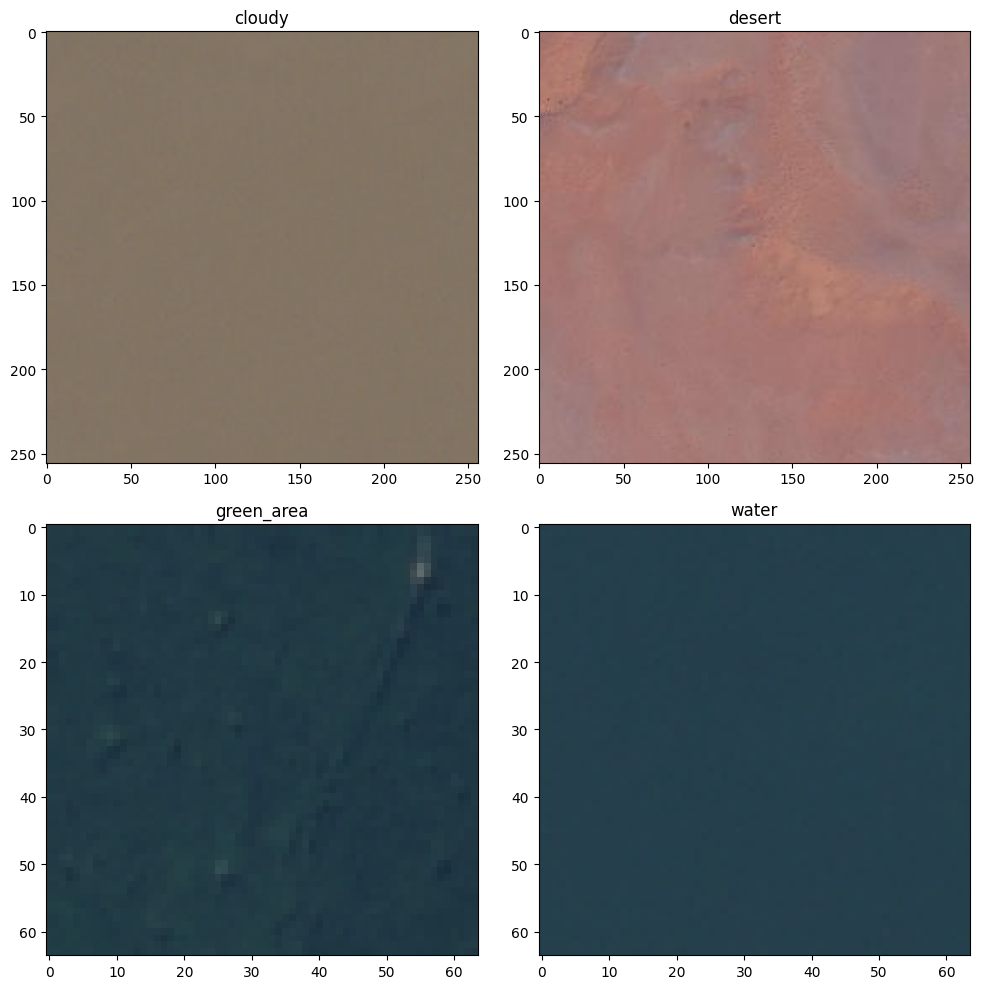

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the folder containing the images
data_dir = '/content/extracted_files/data/'

# List of class names
class_names = ["cloudy", "desert", "green_area", "water"]

# Display one random image from each class in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, class_name in enumerate(class_names):
    row = i // 2
    col = i % 2
    class_dir = os.path.join(data_dir, class_name)
    img_file = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_file)
    img = mpimg.imread(img_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(class_name)

plt.tight_layout()
plt.show()


##Imports

In [ ]:
#Import neccessary libraries

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

##Data Pre-Processing

In [ ]:
    """
    This function takes a directory path as input and returns two lists:

    - filepaths: A list containing the full paths to all files within the directory and its subdirectories.
    - labels: A list containing the label for each file, corresponding to the subdirectory it belongs to.

    Args:
        dir (str): The path to the directory containing the data.

    Returns:
        tuple: A tuple containing two lists: filepaths and labels.
    """
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


    """
    This function takes two lists as input and creates a pandas DataFrame:

    - files: A list containing file paths.
    - classes: A list containing labels for each file.

    Args:
        files (list): List of file paths.
        classes (list): List of labels corresponding to each file path.

    Returns:
        pandas.DataFrame: A DataFrame containing two columns: 'filepaths' and 'labels'.
    """
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


    """
    This function takes a directory path as input and creates a pandas DataFrame containing file paths and labels.

    Args:
        dir (str): The path to the directory containing the data.

    Returns:
        pandas.DataFrame: A DataFrame containing two columns: 'filepaths' and 'labels'.
    """

def create_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [ ]:
    """
    This function creates data generators for training, validation, and testing using Keras' ImageDataGenerator class.

    Args:
        train_df (pandas.DataFrame): DataFrame containing training data with 'filepaths' and 'labels' columns.
        valid_df (pandas.DataFrame): DataFrame containing validation data with 'filepaths' and 'labels' columns.
        test_df (pandas.DataFrame): DataFrame containing testing data with 'filepaths' and 'labels' columns.
        batch_size (int): The number of samples per batch for the generators.

    Returns:
        tuple: A tuple containing three data generators: train_gen, valid_gen, and test_gen.
    """
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)  # Target image size for resizing
    channels = 3  #RGB images with 3 channels
    img_shape = (img_size[0], img_size[1], channels)  # Image shape for data generators
    ts_length = len(test_df)

    # Define a simple scalar function for basic preprocessing (can be replaced with more complex preprocessing)
    def scalar(img):
        return img

    # Create data generators with specific configurations

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True) # Train generator with horizontal flips for augmentation
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)  # Test/Validation generator with only scalar preprocessing


    # Use flow_from_dataframe to create generators from DataFrames
    train_gen = tr_gen.flow_from_dataframe( train_df,
                                           x_col= 'filepaths', # Column containing image file paths
                                           y_col= 'labels',   # Column containing class labels
                                           target_size= img_size, # Resize images to target size
                                           class_mode= 'categorical', # One-hot encode labels for categorical classification
                                            color_mode= 'rgb',   # Assuming RGB images
                                            shuffle= True,  # Shuffle data for training
                                            batch_size= 40)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 40)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= 40)
    return train_gen, valid_gen, test_gen


dir = '/content/extracted_files/data'

# Create a DataFrame containing filepaths and labels
df = create_df(dir)

# Split data into training, validation, and testing sets
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

# Get Generators
batch_size = 200

# Create data generators for training, validation, and testing
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 4504 validated image filenames belonging to 4 classes.
Found 564 validated image filenames belonging to 4 classes.
Found 563 validated image filenames belonging to 4 classes.


In [ ]:
train_df

,filepaths,labels
3209,/content/extracted_files/data/cloudy/train_311...,cloudy
2077,/content/extracted_files/data/desert/desert(14...,desert
2131,/content/extracted_files/data/desert/desert(80...,desert
2254,/content/extracted_files/data/desert/desert(10...,desert
4998,/content/extracted_files/data/green_area/Fores...,green_area
...,...,...
3772,/content/extracted_files/data/cloudy/train_405...,cloudy
5191,/content/extracted_files/data/green_area/Fores...,green_area
5226,/content/extracted_files/data/green_area/Fores...,green_area
5390,/content/extracted_files/data/green_area/Fores...,green_area


In [ ]:
test_df

,filepaths,labels
5102,/content/extracted_files/data/green_area/Fores...,green_area
4507,/content/extracted_files/data/green_area/Fores...,green_area
3787,/content/extracted_files/data/cloudy/train_193...,cloudy
437,/content/extracted_files/data/water/SeaLake_65...,water
1988,/content/extracted_files/data/desert/desert(62...,desert
...,...,...
1773,/content/extracted_files/data/desert/desert(73...,desert
4085,/content/extracted_files/data/cloudy/train_166...,cloudy
43,/content/extracted_files/data/water/SeaLake_72...,water
5277,/content/extracted_files/data/green_area/Fores...,green_area


In [ ]:
test_df.shape

(563, 2)

In [ ]:
train_df.shape

(4504, 2)

In [ ]:
valid_df.shape

(564, 2)

##Time and Learning Rate


TimeHistory: This callback class is used to monitor the training time. It keeps track of the start time of training, individual epoch times, and prints the total training time and each epoch's execution time.
lr_schedule: This function defines a learning rate schedule that reduces the learning rate by a factor of 10 after every 10 epochs. It starts with a learning rate of 0.001 and reduces it to 0.0001 after 10 epochs and further to 0.00001 after 20 epochs. This is a simple example, and you can modify the logic to implement more complex learning rate schedules.

In [ ]:
import time
from tensorflow.keras.callbacks import LearningRateScheduler


"""
This custom callback class tracks the execution time of training epochs and the total training time.

It provides methods for:
    - on_train_begin: Initializes empty lists to store epoch times and starts the overall training timer.
    - on_epoch_begin: Records the start time for the current epoch.
    - on_epoch_end: Calculates the epoch execution time, stores it, and prints the result.
    - on_train_end: Calculates the total training time and prints the result.
"""

# Define a custom callback to track execution time
class TimeHistory(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.times = []
        self.start_time = time.time()  # Start time of the entire training process

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        self.times.append(epoch_time)
        print(f"Epoch {len(self.times)} - Execution Time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs={}):
        total_time = time.time() - self.start_time
        print(f"Total Training Time: {total_time:.2f} seconds")

# Define a custom learning rate scheduler function
def lr_schedule(epoch):
    learning_rate = 0.001 # Initial learning rate
    if epoch > 10:
        learning_rate = 0.0001 # Reduce by 10x after 10 epochs
    elif epoch > 20:
        learning_rate = 0.00001 # Reduce by 100x after 20 epochs
    return learning_rate

##Models



The below code defines and compiles a convolutional neural network (CNN) models for image classification using a pre-trained  EfficientNetB3, ResNet50 and VGG16 models as a feature extractor.

Import Libraries: Imports necessary libraries for building and compiling the models (TensorFlow and Keras).
Define Image Dimensions and Class Count: Sets the image size (img_size) and number of channels (channels). It also retrieves the number of classes (class_count) from the train_gen data generator (assuming it contains class labels).
Load Pre-trained Model: Loads the EfficientNetB3, ResNet50 and VGG16 (loaded seperately in the below code blocks) pre-trained models from TensorFlow Hub. It specifies include_top=False to exclude the top classification layers and weights='imagenet' to load weights pre-trained on the ImageNet dataset. It also sets the input_shape and pooling strategy for the model.
Freeze Pre-trained Model Layers: Sets all layers in the pre-trained model to be non-trainable (freezing the weights). This is common practice when using pre-trained models for feature extraction, as we don't want to significantly alter the learned features from the original dataset.
Build Classifier Model: Creates a Sequential model on top of the pre-trained model.
 This model consists of:
BatchNormalization: A layer for normalizing the internal data distribution.
Dense layer: A fully-connected layer with 256 neurons and ReLU activation.
Dropout layer: A layer that randomly drops out 50% of the neurons during training to prevent overfitting.
Another Dense layer with 64 neurons and ReLU activation.
Another Dropout layer with 50% probability.
Output layer: A Dense layer with the number of neurons equal to the number of classes and softmax activation for multi-class classification.
Compile the Model: Compiles the model with the Adam optimizer, categorical crossentropy loss function (suitable for multi-class classification with one-hot encoded labels), and accuracy metric.

Similar Structure is followed for all three models, so that the best model which is suitable for the given dataset is selceted for the final prediction,

###EfficientNetB3

EfficentNet is an efficient network that has many convolutional neural layers.
EfficentNetB3 has many convolution layers that extract the feature map of the input images to perform the classification task.
EfficientNet-B3 is one of the models in the EfficientNet family, which is considered a balanced and efficient model.
One of the critical innovations of EfficientNet-B3 is using a compound scaling method to automatically scale up the model’s architecture, in terms of depth (number of layers) and width (number of filters per layer), based on the input image resolution



####Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Define image dimensions and number of classes
img_size = (224, 224)  # Input image size (width, height)
channels = 3  # Number of color channels (RGB)
img_shape = (img_size[0], img_size[1], channels)  # Combined image shape for model input

class_count = len(list(train_gen.class_indices.keys()))  # Assuming train_gen is a data generator with class labels


# Load a pre-trained model (EfficientNetB3)
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,  # Exclude the top classification layers for transfer learning
    weights="imagenet",  # Load pre-trained weights trained on the ImageNet dataset
    input_shape=img_shape,  # Specify the input shape of the model
    pooling='max'        # Use max pooling as the pooling strategy
)

# Freeze the pre-trained model layers (not trainable during this phase)
for layer in base_model.layers:
    layer.trainable = False  # Freeze pre-trained model layers to avoid altering learned features

# Build the final classifier model on top of the pre-trained model
model_efficientnet = Sequential([
    base_model,                                 # Input layer (pre-trained EfficientNetB3)
    BatchNormalization(),                        # Batch normalization for internal data distribution
    Dense(256, activation='relu'),             # Dense layer with 256 neurons and ReLU activation
    Dropout(0.5),                               # Dropout layer with 50% probability to prevent overfitting
    Dense(64, activation='relu'),              # Dense layer with 64 neurons and ReLU activation
    Dropout(0.5),                               # Dropout layer with 50% probability to prevent overfitting
    Dense(class_count, activation='softmax')    # Output layer with softmax activation for multi-class classification (number of neurons equals number of classes)
])

# Compile the model with optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam()  # Adam optimizer for efficient training
model_efficientnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Compile with categorical crossentropy loss for multi-class classification and accuracy metric


####Model Training

The code `lr_scheduler = LearningRateScheduler(lr_schedule)` creates a learning rate scheduler callback using the `LearningRateScheduler` class provided by Keras.

In Keras, a learning rate scheduler is a callback that allows you to schedule the learning rate to change during training according to a predefined function. In this case, the `LearningRateScheduler` callback is initialized with the `lr_schedule` function that is defined earlier.

So, when training the model, the learning rate scheduler callback `lr_scheduler` will be called at the beginning of each epoch. It will use the `lr_schedule` function to determine the learning rate for that epoch based on the current epoch number. This allows for dynamic adjustment of the learning rate as training progresses according to the schedule defined in the `lr_schedule` function.

The model is trained for 15 epochs because of the limited computation power available in colab.

In [ ]:
# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define filepath to save the best model
filepath = 'best_model.h5'


# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Create custom callback to track execution time
time_callback = TimeHistory()


# Train the model with the added callback
history_efficientnet = model_efficientnet.fit(
    x=train_gen,
    epochs=15,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint, lr_scheduler, time_callback]
)

Epoch 1/15
113/113 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.8215
Epoch 1: val_accuracy improved from -inf to 0.97872, saving model to best_model.h5
Epoch 1 - Execution Time: 31.91 seconds
113/113 [==============================] - 32s 185ms/step - loss: 0.5399 - accuracy: 0.8215 - val_loss: 0.0551 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 2/15
113/113 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9203
Epoch 2: val_accuracy improved from 0.97872 to 0.98936, saving model to best_model.h5
Epoch 2 - Execution Time: 23.51 seconds
113/113 [==============================] - 24s 208ms/step - loss: 0.2540 - accuracy: 0.9203 - val_loss: 0.0306 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 3/15
113/113 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9414
Epoch 3: val_accuracy did not improve from 0.98936
Epoch 3 - Execution Time: 18.26 seconds
113/113 [==============================] - 18s 161ms/step - loss: 0.1868 - acc

In [ ]:
#Saving the Best model from the training to the drive to be used later

from google.colab import drive
import shutil


# Define the paths
source_filepath = '/content/best_model.h5'
destination_filepath = '/content/drive/MyDrive/GGE6322/best_model_efficientnet.h5'

# Copy the file to Google Drive
shutil.copy(source_filepath, destination_filepath)

# Print a message to confirm that the file has been copied
print("File copied to Google Drive at:", destination_filepath)



File copied to Google Drive at: /content/drive/MyDrive/GGE6322/best_model_efficientnet.h5


####Model Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

# Load the pre-trained model
model= load_model('best_model.h5')

ts_length = len(test_df)

# Calculate an optimal test batch size (ensures efficient evaluation)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

# Calculate the number of evaluation steps for the test data
test_steps = ts_length // test_batch_size

# Evaluate the model on training data
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)

# Evaluate the model on validation data
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)

# Evaluate the model on test data
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

# Print the evaluation results for each dataset (train, validation, test)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

113/563 [=====>........................] - ETA: 1:08 - loss: 0.0157 - accuracy: 0.9944

 14/563 [..............................] - ETA: 1:14 - loss: 0.0147 - accuracy: 0.9964

 15/563 [..............................] - ETA: 1:52 - loss: 0.0893 - accuracy: 0.9822

563/563 [==============================] - 3s 5ms/step - loss: 0.0893 - accuracy: 0.9822
Train Loss:  0.015746325254440308
Train Accuracy:  0.9944493770599365
--------------------
Validation Loss:  0.01463883277028799
Validation Accuracy:  0.9964538812637329
--------------------
Test Loss:  0.08928228169679642
Test Accuracy:  0.9822379946708679


####Model Prediction

In [ ]:
# Load the saved model
model = load_model('best_model.h5')

# Predict class probabilities on the test data
preds = model.predict_generator(test_gen)

# Get the predicted class labels from the probabilities
y_pred = np.argmax(preds, axis=1)

# Print the predicted class labels
print(y_pred)


<ipython-input-15-c704b8641e8f>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 0 1 2 3 0 3 1 0 0 1 0 2 3 2 3 2 3 1 1 0 1 0 2 0 3 3 0 2 1 3 2 2 0 2 0 1
 2 0 0 0 0 2 0 0 2 0 0 0 3 2 3 0 0 1 2 2 3 2 0 1 2 2 3 3 3 0 2 3 2 0 0 3 1
 3 0 3 0 1 2 0 2 3 0 0 2 3 3 0 1 1 0 1 2 0 2 0 3 2 0 2 3 0 3 2 1 0 3 0 0 1
 3 0 2 2 1 2 0 0 3 0 0 1 2 2 0 1 1 1 3 0 3 0 1 0 0 3 2 3 0 1 2 2 3 3 2 2 2
 0 2 2 0 1 1 3 2 2 1 0 2 2 3 1 0 2 0 2 0 2 1 1 2 2 2 1 0 0 0 0 1 1 1 3 3 2
 0 2 2 1 0 3 3 2 0 3 2 3 2 1 2 2 1 3 0 2 3 2 3 3 0 0 3 2 0 2 1 3 2 3 3 2 2
 0 2 0 2 3 2 2 1 0 1 2 3 2 3 1 2 3 2 2 0 0 3 2 2 2 3 2 3 3 2 0 0 2 3 3 3 0
 0 2 2 3 2 2 0 1 2 3 0 1 0 2 3 2 2 1 0 2 2 2 3 0 3 3 2 0 1 0 0 2 2 1 2 0 1
 1 0 2 0 0 0 2 2 3 3 3 3 3 3 0 3 0 0 2 0 0 3 3 3 2 3 0 2 2 0 2 2 3 1 0 0 2
 2 0 3 3 0 0 3 0 0 2 3 2 0 2 0 3 0 1 0 3 3 0 3 2 3 0 0 1 2 1 3 0 3 3 0 1 2
 1 3 0 2 2 3 1 0 0 1 3 3 3 2 1 1 0 2 3 0 2 0 2 0 3 3 3 3 2 0 1 2 2 2 1 0 0
 1 2 2 2 2 3 2 1 0 1 1 2 2 3 3 0 2 0 2 2 0 3 0 3 3 1 0 3 3 2 3 1 2 2 3 3 3
 2 3 1 1 0 0 3 0 1 3 2 2 3 2 1 0 2 3 0 3 1 2 0 1 3 2 0 1 3 0 1 1 1 1 2 3 2
 1 2 3 3 3 1 2 3 0 2 0 3 

Confusion matrices are a valuable tool for evaluating the performance of classification models. They provide a clear visualization of how often each predicted class label appears for each true class label. This function, plot_confusion_matrix, creates a heatmap to represent this information.

In [ ]:
import itertools
import matplotlib.pyplot as plt

 """
  This function creates and displays a confusion matrix as a heatmap.

  Args:
      cm (numpy.ndarray): The confusion matrix, a 2D array containing counts of how often each predicted class label appears for each true class label.
      classes (list): A list of strings representing the class labels.
      normalize (bool, optional): Whether to normalize the confusion matrix values. Defaults to False.
          Normalization divides each value by the sum of values in its corresponding true label row, resulting in proportions between 0 and 1.
      title (str, optional): The title for the plot. Defaults to 'Confusion Matrix'.
      cmap (matplotlib.colors.Colormap, optional): The colormap used for the heatmap. Defaults to plt.cm.Blues.

  Returns:
      None
  """


def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[153   0   0   1]
 [  0  96   0   0]
 [  0   0 166   0]
 [  5   1   3 138]]
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       154
           2       0.99      1.00      0.99        96
           3       0.98      1.00      0.99       166
           4       0.99      0.94      0.97       147

    accuracy                           0.98       563
   macro avg       0.98      0.98      0.98       563
weighted avg       0.98      0.98      0.98       563



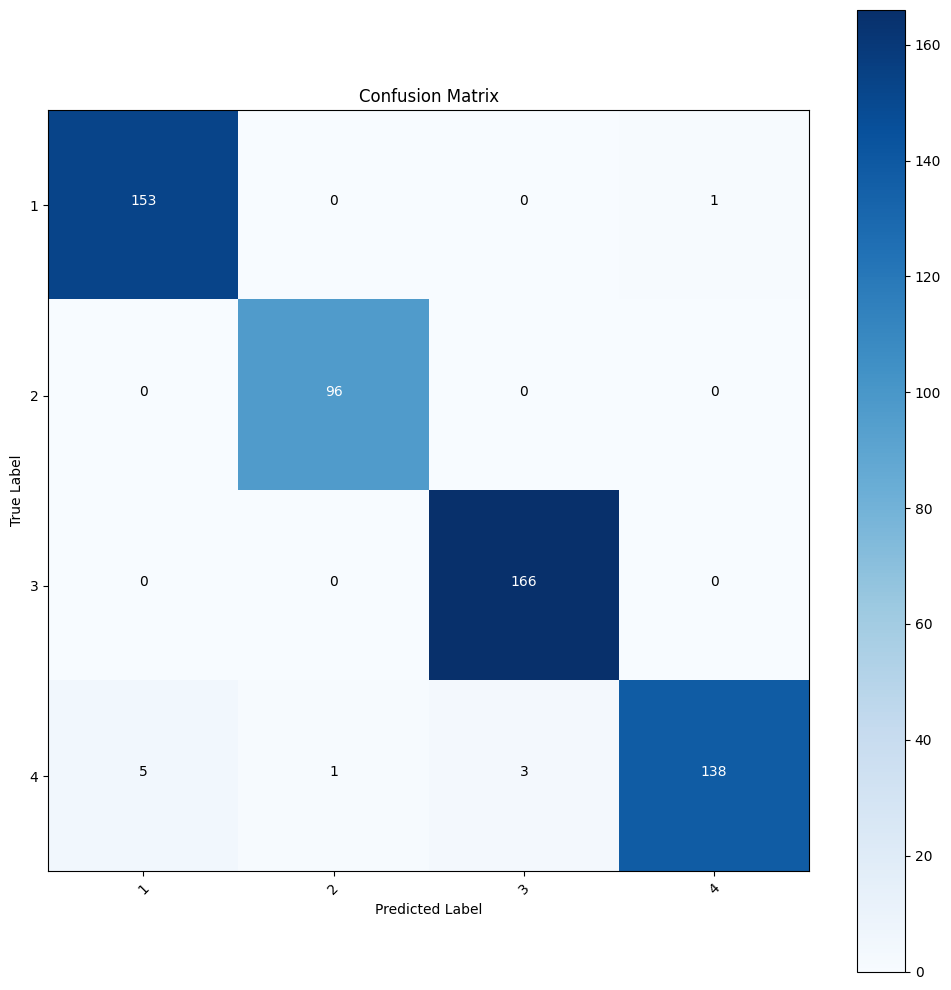

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['1','2','3','4']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

###ResNet50

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer.
One of its key innovations is the use of residual connections.
ResNet50 has been trained on large datasets and achieves state-of-the-art results on several benchmarks.
It has been trained on the ImageNet dataset, which contains over 14 million images and 1000 classes.


####Model Building

In [ ]:
## Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators for training and validation data
img_size = (224, 224)  # Target image size for the model
channels = 3            #  RGB images (3 channels)
img_shape = (img_size[0], img_size[1], channels)

# Get the number of classes from your training data generator
class_count = len(list(train_gen.class_indices.keys()))

## Create the pre-trained model base
# Load a pre-trained ResNet50 model (without the final classification layers)
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # Exclude the top (classification) layers
    weights="imagenet",  # Load pre-trained weights trained on ImageNet dataset
    input_shape=img_shape,  # Specify the input shape of the model
    pooling='max'       # Use max pooling as the final pooling layer in the base model
)

# Freeze the pre-trained model layers (not train their weights)
for layer in base_model.layers:
    layer.trainable = False

## Build the classifier head on top of the pre-trained model
model_resnet = Sequential([
    base_model,                                 # Add the pre-trained model as the first layer
    BatchNormalization(),                        # Add batch normalization for improved training stability
    Dense(256, activation='relu'),              # Add a dense layer with 256 neurons and ReLU activation
    Dropout(0.5),                               # Add dropout layer with 50% drop rate for regularization
    Dense(64, activation='relu'),               # Add another dense layer with 64 neurons and ReLU activation
    Dropout(0.5),                               # Another dropout layer with 50% drop rate
    Dense(class_count, activation='softmax')     # Final dense layer with the number of classes and softmax activation
])

## Compile the model for training
optimizer = tf.keras.optimizers.Adam()  # Use Adam optimizer for training
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



94765736/94765736 [==============================] - 0s 0us/step


####Model Training

In [ ]:
# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',  # Monitor validation accuracy for saving the best model
    verbose=1,                # Print information at each epoch when a checkpoint is saved
    save_best_only=True,       # Only save the model with the highest validation accuracy
    mode='max'                 # Save the model with the highest validation accuracy
)

# Create custom callback to track execution time
time_callback = TimeHistory()

# Train the model with the added callbacks
history_resnet = model_resnet.fit(
    x=train_gen,
    epochs=15,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint, lr_scheduler, time_callback]
)


Epoch 1/15
113/113 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.8892
Epoch 1: val_accuracy improved from -inf to 0.97872, saving model to best_model_resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1 - Execution Time: 27.14 seconds
113/113 [==============================] - 27s 181ms/step - loss: 0.3857 - accuracy: 0.8892 - val_loss: 0.0571 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 2/15
113/113 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9665
Epoch 2: val_accuracy improved from 0.97872 to 0.99468, saving model to best_model_resnet.h5
Epoch 2 - Execution Time: 18.19 seconds
113/113 [==============================] - 18s 160ms/step - loss: 0.1297 - accuracy: 0.9665 - val_loss: 0.0164 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 3/15
113/113 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9716
Epoch 3: val_accuracy improved from 0.99468 to 0.99645, saving model to best_model_resnet.h5
Epoch 3 - Execution Time: 17.28 seconds
113/113 [==============================] - 17s 152ms/step - loss: 0.1057 - accuracy: 0.9716 - val_loss: 0.0091 - val_accuracy: 0.9965 - lr: 0.0010
Epoch 4/15
113/113 [==============================] - ETA: 0s

In [ ]:
#Saving the Best model to drive for later use
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths
source_filepath = '/content/best_model_resnet.h5'
destination_filepath = '/content/drive/MyDrive/GGE6322/best_model_resnet.h5'

# Copy the file to Google Drive
shutil.copy(source_filepath, destination_filepath)

# Print a message to confirm that the file has been copied
print("File copied to Google Drive at:", destination_filepath)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File copied to Google Drive at: /content/drive/MyDrive/GGE6322/best_model_resnet.h5


####Model Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

# Load the best saved model
model = load_model('best_model_resnet.h5')

# Get the length of your test data
ts_length = len(test_df)

# Calculate an efficient test batch size (divisible by the data length and <= 80)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Calculate the number of batches required for evaluation (test_steps) based on test data length and batch size
test_steps = ts_length // test_batch_size

# Evaluate the model on the training data (might be used for debugging or comparison)
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)

# Evaluate the model on the validation data
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)

# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print the evaluation metrics for each dataset split
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


113/563 [=====>........................] - ETA: 59s - loss: 0.0011 - accuracy: 1.0000 

 14/563 [..............................] - ETA: 1:11 - loss: 0.0019 - accuracy: 1.0000

 15/563 [..............................] - ETA: 1:40 - loss: 0.0105 - accuracy: 0.9982

563/563 [==============================] - 3s 5ms/step - loss: 0.0105 - accuracy: 0.9982
Train Loss:  0.0010983434040099382
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0019292476354166865
Validation Accuracy:  1.0
--------------------
Test Loss:  0.010490862652659416
Test Accuracy:  0.9982237815856934


####Model Prediction

In [ ]:
# Load the best saved model
model = load_model('best_model_resnet.h5')

# Predict class probabilities on the test data
preds = model.predict_generator(test_gen)

# Get the predicted class labels from the probabilities
y_pred = np.argmax(preds, axis=1)

# Print the predicted class labels
print(y_pred)


<ipython-input-22-edc74298ee48>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 0 1 2 3 0 3 1 0 0 1 0 2 3 2 3 2 3 1 1 3 1 0 2 3 3 3 0 2 1 3 2 2 0 2 0 1
 2 0 0 0 0 2 0 0 2 0 0 0 3 2 3 0 3 1 2 2 3 2 0 1 2 2 3 3 3 0 2 3 2 0 0 3 1
 3 0 3 0 1 2 0 2 3 0 0 2 3 3 0 1 1 0 1 2 0 2 0 3 2 0 3 3 0 3 2 1 0 3 0 0 1
 3 0 2 2 1 2 0 3 3 0 0 1 2 2 0 1 1 1 3 0 3 0 1 0 0 3 2 3 0 1 2 2 3 3 2 2 2
 0 2 2 0 1 1 3 2 2 1 0 2 2 3 1 0 2 0 2 0 2 1 1 2 2 2 1 0 3 0 0 1 1 1 3 3 2
 0 2 2 1 0 3 3 2 0 3 2 3 2 1 2 2 1 3 0 2 3 2 3 0 0 0 3 2 0 2 1 3 2 3 3 2 2
 0 2 0 2 3 2 2 1 0 1 2 3 2 3 1 2 3 2 2 0 0 3 2 2 2 3 2 3 3 2 0 0 2 3 3 3 0
 0 2 2 3 2 2 0 1 2 3 0 1 0 2 3 2 2 1 0 3 2 2 3 0 3 3 2 0 1 0 0 2 2 1 2 0 1
 1 0 2 0 0 0 2 2 3 3 3 3 3 3 0 3 0 0 2 0 0 3 3 3 2 3 0 2 2 0 2 2 3 1 0 0 2
 2 0 3 3 0 0 3 0 0 2 3 2 0 2 0 3 0 1 0 3 3 0 3 3 3 0 0 1 2 1 3 0 3 3 0 1 2
 1 3 0 2 2 3 1 0 0 1 3 3 3 2 1 1 0 2 3 0 2 0 2 0 3 3 3 3 2 0 1 2 2 2 1 0 0
 1 2 2 2 2 3 2 1 0 1 1 2 2 3 3 0 2 0 2 2 0 3 0 3 3 1 0 3 3 2 3 1 2 2 3 3 3
 2 3 3 1 0 0 3 0 1 3 2 2 3 2 1 0 2 3 0 3 1 2 0 1 3 2 0 1 3 0 1 1 1 1 2 3 2
 1 2 3 3 3 1 2 3 0 2 0 3 

Confusion Matrix, Without Normalization
[[154   0   0   0]
 [  0  96   0   0]
 [  0   0 165   1]
 [  0   0   0 147]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       154
           2       1.00      1.00      1.00        96
           3       1.00      0.99      1.00       166
           4       0.99      1.00      1.00       147

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563



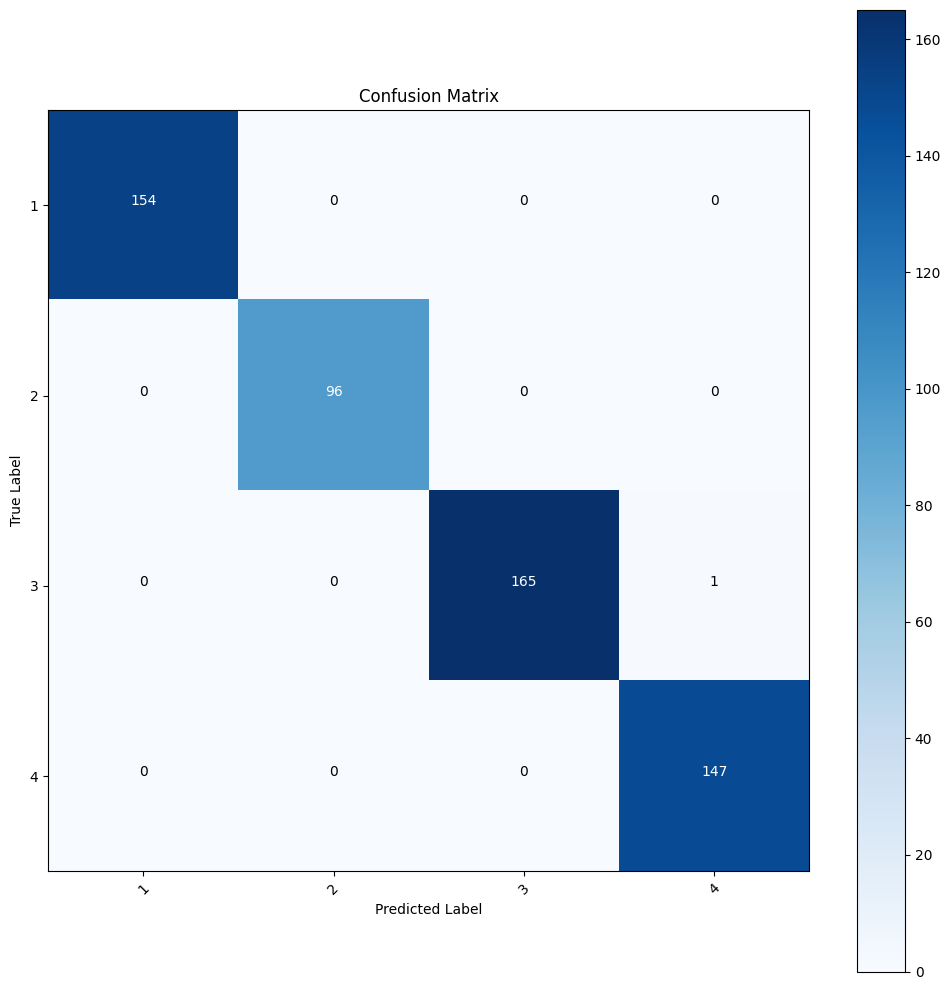

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['1','2','3','4']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

###VGG16

VGG16 is a deep convolutional neural network model used for image classification tasks. The network is composed of 16 layers of artificial neurons, which each work to process image information incrementally and improve the accuracy of its predictions.
VGG16 is effective at extracting hierarchical features from images, starting from simple features (e.g., edges and textures) in the early layers to more abstract features (e.g., object parts and object classes) in the deeper layers.


####Model Building

In [ ]:
## Similar structure to the previous model using ResNet

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

#  train_gen and valid_gen are your image data generators

img_size = (224, 224)  # Target image size for the model
channels = 3            # RGB images (3 channels)
img_shape = (img_size[0], img_size[1], channels)

# Get the number of classes from your training data generator
class_count = len(list(train_gen.class_indices.keys()))

## Create the pre-trained model base
# Load a pre-trained VGG16 model (without the final classification layers)
base_model = tf.keras.applications.VGG16(
    include_top=False,  # Exclude the top (classification) layers
    weights="imagenet",  # Load pre-trained weights trained on ImageNet dataset
    input_shape=img_shape,  # Specify the input shape of the model
    pooling='max'       # Use max pooling as the final pooling layer in the base model
)

# Freeze the pre-trained model layers (not train their weights)
for layer in base_model.layers:
    layer.trainable = False

## Build the classifier head on top of the pre-trained model
model_vgg = Sequential([
    base_model,                                 # Add the pre-trained model as the first layer
    BatchNormalization(),                        # Add batch normalization for improved training stability
    Dense(256, activation='relu'),              # Add a dense layer with 256 neurons and ReLU activation
    Dropout(0.5),                               # Add dropout layer with 50% drop rate for regularization
    Dense(64, activation='relu'),               # Add another dense layer with 64 neurons and ReLU activation
    Dropout(0.5),                               # Another dropout layer with 50% drop rate
    Dense(class_count, activation='softmax')     # Final dense layer with the number of classes and softmax activation
])

## Compile the model for training
optimizer = tf.keras.optimizers.Adam()  # Use Adam optimizer for training
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


####Model Training

In [ ]:
# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define filepath to save the best model
filepath = 'best_model_vgg.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Create custom callback to track execution time
time_callback = TimeHistory()

# Train the model with the added callback
history_vgg = model_vgg.fit(
    x=train_gen,
    epochs=15,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint, lr_scheduler, time_callback]
)

Epoch 1/15
113/113 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.8213
Epoch 1: val_accuracy improved from -inf to 0.95390, saving model to best_model_vgg.h5
Epoch 1 - Execution Time: 38.42 seconds
113/113 [==============================] - 38s 260ms/step - loss: 0.5213 - accuracy: 0.8213 - val_loss: 0.1315 - val_accuracy: 0.9539 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/15
113/113 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9465
Epoch 2: val_accuracy improved from 0.95390 to 0.98050, saving model to best_model_vgg.h5
Epoch 2 - Execution Time: 22.47 seconds
113/113 [==============================] - 22s 198ms/step - loss: 0.1614 - accuracy: 0.9465 - val_loss: 0.0529 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 3/15
113/113 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9587
Epoch 3: val_accuracy improved from 0.98050 to 0.98936, saving model to best_model_vgg.h5
Epoch 3 - Execution Time: 22.47 seconds
113/113 [==============================] - 22s 199ms/step - loss: 0.1254 - accuracy: 0.9587 - val_loss: 0.0257 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 4/15
113/113 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9714
Epoch 4: val_accuracy improved from 0.98936 to 0.99645, saving model to best_model_vgg.h5
Epoch 4 - Execution Time: 22.08 seconds
113/113 [===================

In [ ]:
#Save the best model to the drive
# Define the paths
source_filepath = '/content/best_model_vgg.h5'
destination_filepath = '/content/drive/MyDrive/GGE6322/best_model_vgg.h5'

# Copy the file to Google Drive
shutil.copy(source_filepath, destination_filepath)

# Print a message to confirm that the file has been copied
print("File copied to Google Drive at:", destination_filepath)



File copied to Google Drive at: /content/drive/MyDrive/GGE6322/best_model_vgg.h5


####Model Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average  # Assuming Average is for ensemble, replace if different

# Load the best saved model (assuming filename is 'best_model_vgg.h5')
model = load_model('best_model_vgg.h5')

# Get the length of the test data
ts_length = len(test_df)

# Calculate an efficient test batch size (divisible by data length and <= 80)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Calculate the number of batches required for evaluation (test_steps)
test_steps = ts_length // test_batch_size

# Evaluate the model on the training data
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)

# Evaluate the model on the validation data
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)

# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print the evaluation metrics for each dataset split
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


113/563 [=====>........................] - ETA: 1:16 - loss: 0.0203 - accuracy: 0.9933

 14/563 [..............................] - ETA: 1:34 - loss: 0.0085 - accuracy: 0.9982

 15/563 [..............................] - ETA: 2:23 - loss: 0.0401 - accuracy: 0.9876

563/563 [==============================] - 4s 7ms/step - loss: 0.0401 - accuracy: 0.9876
Train Loss:  0.02027122676372528
Train Accuracy:  0.9933392405509949
--------------------
Validation Loss:  0.008420668542385101
Validation Accuracy:  0.9982269406318665
--------------------
Test Loss:  0.04014286398887634
Test Accuracy:  0.9875665903091431


####Model Prediction

In [ ]:
# Load the saved VGG model
model = load_model('best_model_vgg.h5')

# Predict class probabilities on the test data using the loaded model
preds = model.predict(test_gen)

# Get the predicted class labels from the class probabilities
y_pred = np.argmax(preds, axis=1)

# Print the predicted class labels for all test images
print(y_pred)


15/15 [==============================] - 3s 168ms/step
[0 0 1 2 3 0 3 1 0 0 1 0 2 3 2 3 2 3 1 1 3 1 3 2 3 3 3 0 2 1 3 2 2 0 2 0 1
 2 0 0 0 0 2 0 0 2 0 0 0 3 2 3 0 3 1 2 2 3 2 0 1 2 2 3 3 3 0 2 3 2 0 0 3 1
 3 0 3 0 1 2 0 2 3 0 0 2 3 3 0 1 1 0 1 2 0 2 0 3 2 0 2 3 0 3 2 1 0 3 0 0 1
 3 0 2 2 1 2 0 0 3 0 0 1 2 2 0 1 1 1 3 0 3 0 1 0 0 3 2 3 0 1 2 2 3 3 2 2 2
 0 2 2 0 1 1 3 2 2 1 0 2 2 3 1 0 2 0 2 0 2 1 1 2 2 2 1 0 3 0 0 1 1 1 3 3 2
 0 2 2 1 0 3 3 2 0 3 2 3 2 1 2 2 1 3 0 2 3 2 3 3 0 0 3 2 0 2 1 3 2 3 3 2 2
 0 2 0 2 3 2 2 1 0 1 2 3 2 3 1 2 3 2 2 0 0 3 2 2 2 3 2 3 3 2 0 0 2 3 2 3 0
 0 2 2 3 2 2 0 1 2 3 0 1 0 2 3 2 2 1 0 2 2 2 3 0 3 3 2 0 1 0 0 2 2 1 2 0 1
 1 0 2 0 0 0 2 2 3 3 3 3 3 3 0 3 0 0 2 0 0 3 3 3 2 3 0 2 2 0 2 2 3 1 0 0 2
 2 0 3 3 0 0 3 0 0 2 3 2 0 2 0 3 0 1 0 3 3 0 3 2 3 0 0 1 2 1 3 0 3 3 0 1 2
 1 3 0 2 2 3 1 0 0 1 3 3 3 2 1 1 0 2 3 0 2 0 2 0 3 3 3 3 2 0 1 2 2 2 1 0 3
 1 2 2 2 2 3 2 1 0 1 1 2 2 3 3 0 2 0 2 2 0 3 0 3 3 1 0 3 3 2 3 1 2 2 3 3 3
 2 3 3 1 0 0 3 0 1 3 2 2 3 2 1 0 2 3 0 3 1 2 

Confusion Matrix, Without Normalization
[[151   0   0   3]
 [  0  96   0   0]
 [  0   0 166   0]
 [  1   0   3 143]]
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       154
           2       1.00      1.00      1.00        96
           3       0.98      1.00      0.99       166
           4       0.98      0.97      0.98       147

    accuracy                           0.99       563
   macro avg       0.99      0.99      0.99       563
weighted avg       0.99      0.99      0.99       563



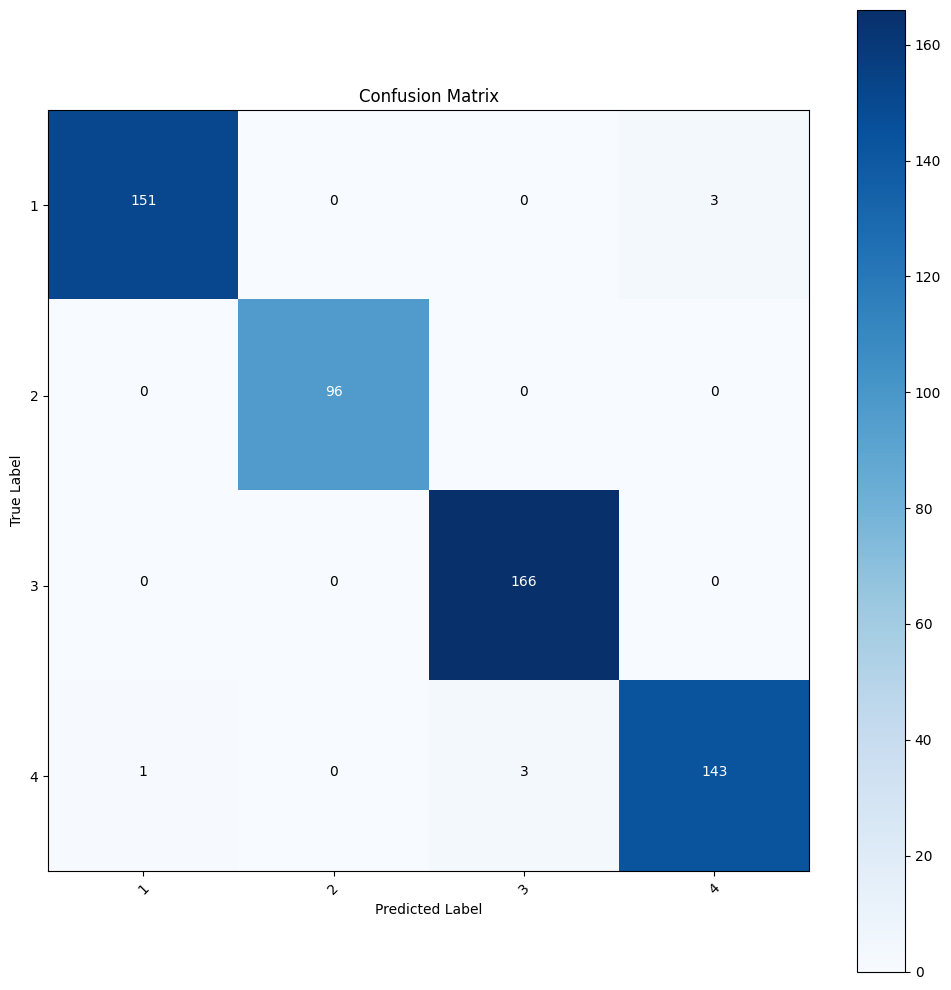

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['1','2','3','4']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

###Model Comparison

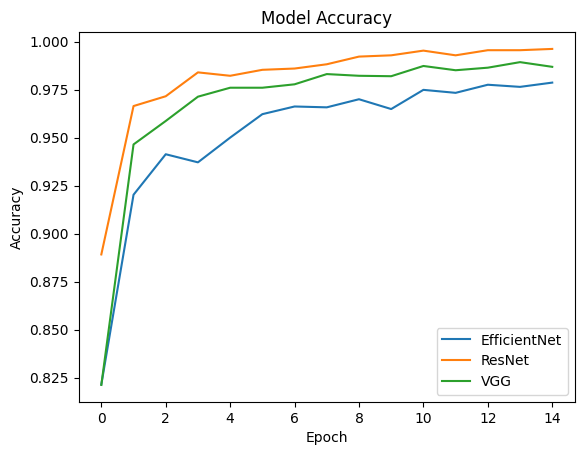

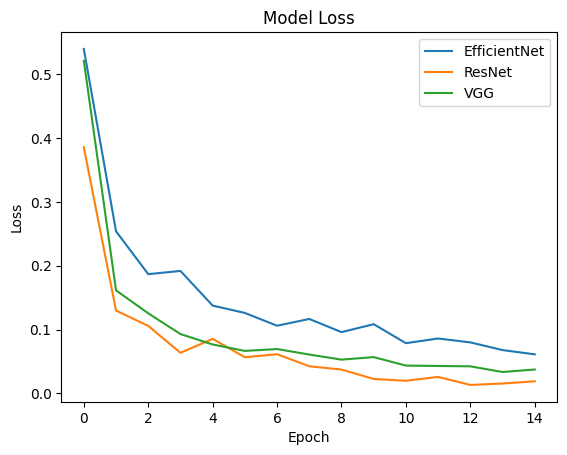

In [ ]:
# Plotting accuracy
plt.plot(history_efficientnet.history['accuracy'], label='EfficientNet')
plt.plot(history_resnet.history['accuracy'], label='ResNet')
plt.plot(history_vgg.history['accuracy'], label='VGG')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Plotting loss
plt.plot(history_efficientnet.history['loss'], label='EfficientNet')
plt.plot(history_resnet.history['loss'], label='ResNet')
plt.plot(history_vgg.history['loss'], label='VGG')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The above metrics offer valuable insights into the performance of EfficientNet, ResNet, and VGG models on satellite image classification task.

**Metrics:**

* **Train Loss:** Represents the model's loss (how well it performs) on the training data it was trained on. Lower values are better.
* **Train Accuracy:** Represents the percentage of images in the training data that the model classified correctly. Higher values are better.
* **Validation Loss:** Evaluates the model's performance on a separate validation dataset not used for training. Lower values indicate better generalization to unseen data.
* **Validation Accuracy:**  Similar to train accuracy, but measured on the validation dataset. Higher values are better.
* **Test Loss:** Represents the model's performance on a final test dataset, ideally unseen during training and validation. Lower values indicate good generalization.
* **Test Accuracy:**  Similar to validation accuracy, but measured on the test dataset. This is typically the most important metric, reflecting how well the model performs on real-world data.

**Model Comparison:**

1. **Test Accuracy:**
    * ResNet achieves the highest test accuracy (0.99822), followed closely by EfficientNet (0.98223) and VGG (0.98756659). This suggests ResNet might perform slightly better on unseen data in this specific case.

2. **Generalization:**
    * Both ResNet and EfficientNet show a smaller gap between training and validation accuracy/loss compared to VGG. This suggests they might generalize better to unseen data.

3. **Training Efficiency:**
    *  EfficientNet is generally known for achieving good accuracy while being more efficient (faster training times) compared to deeper models like ResNet or VGG.

**Overall:**

While ResNet achieves the highest test accuracy here, all three models have very good performance. Choosing the best model depends on our specific needs:

* **Prioritize highest accuracy:** ResNet might be a good choice based on these results.
* **Balance accuracy and efficiency:** EfficientNet is a strong contender, especially if training time or resource usage is a concern.
* **Prefer a simpler architecture (potentially easier to interpret):** ResNet might be preferable due to its skip connections.

**Additional Considerations:**

* The size and quality of the training data can significantly impact model performance.
* Hyperparameter tuning for each model could potentially improve the results further.


###Final Prediction



The final prediction is done on the below image which has all the features of the classification (cloud, green area, dessert/sand and water). The Resnet50 model is chosen as the best model based on the evaluation metrics discussed earlier. The model is loaded and the image is preprocessed to fit into the model requirement for the input image. Then the prediction is done.

1/1 [==============================] - 1s 981ms/step


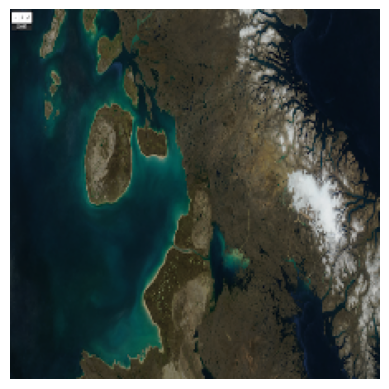

Class 0 (cloudy): 21.36%
Class 1 (desert): 9.83%
Class 2 (green_area): 10.28%
Class 3 (water): 58.54%


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import drive
import matplotlib.pyplot as plt


# Path to the saved model on Google Drive
model_path = '/content/drive/MyDrive/GGE6322/best_model_resnet.h5'

# Load the pre-trained model
model = load_model(model_path)

# Define paths to the image files
image_paths = [
    '/content/drive/MyDrive/GGE6322/predict.png'

]

# Loop through each image file
for image_path in image_paths:
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Rescale pixel values to [0, 1]

    # Make predictions
    predictions = model.predict(img_array)

    # Get class probabilities using softmax
    class_probabilities = np.squeeze(predictions)

    # Calculate percentage for each class
    percentages = class_probabilities * 100

    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Define class names corresponding to each class index
    class_names = ["cloudy", "desert", "green_area", "water"]

# Print the percentages and corresponding class names
    for i, (percentage, class_name) in enumerate(zip(percentages, class_names)):
        print(f"Class {i} ({class_name}): {percentage:.2f}%")

The model predicts "water" with the highest confidence (58.54%), followed by "cloudy" (21.36%), "green_area" (10.28%), and "desert" (9.83%). This suggests that the model believes the image most likely depicts a scene with a significant amount of water.

Model Improvement Considerations
While the model assigns the highest probability to "water," there are some indications that it could benefit from improvement:

Green Area and Cloud Predictions: The model's confidence in "cloudy" (21.36%) and "green_area" (10.28%) is relatively low compared to "water" (58.54%). This suggests the model might be less certain when differentiating between these categories in this specific image.

The beloe are some potential areas for improvement:

Training Data: The model's performance might be enhanced by providing it with a more extensive training dataset containing images that better represent the variations within the "cloudy" and "green_area" classes, especially if these categories are crucial for your application.
Model Architecture or Hyperparameter Tuning: Experimenting with different model architectures or fine-tuning hyperparameters of the current model could potentially improve its ability to distinguish between these classes.
Overall
The model seems to identify the dominant class ("water") in the image with reasonable confidence. However, the relatively low probabilities assigned to "cloudy" and "green_area" indicate room for improvement, particularly if these classifications are important for the specific use case.

###Reference:
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10100945

https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

https://medium.com/@arashserej/resnet-50-83b3ff33be7d

https://www.kaggle.com/code/prthmgoyl/efficientnet-resnet-vgg-satelliteim-classification
